In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from scipy import stats

from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler,OneHotEncoder

from sklearn.linear_model import LinearRegression,Ridge,ElasticNet,Lasso
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor, VotingRegressor,StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.kernel_ridge import KernelRidge

import lightgbm as lgb


In [3]:
train_data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [4]:
train_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [5]:
numeric_columns = train_data.dtypes[train_data.dtypes != 'object']
print(numeric_columns)
print(len(numeric_columns))

Id                 int64
MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice          int64
dtype: object
38


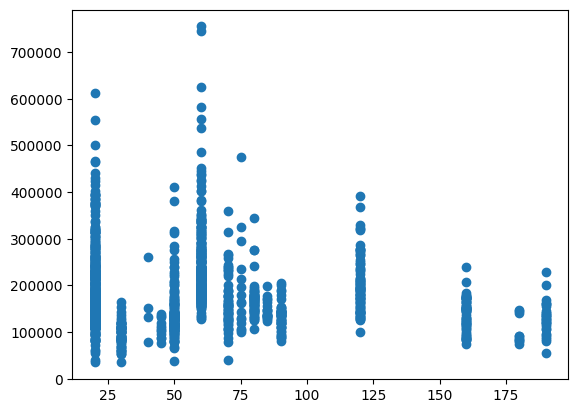

In [6]:
plt.scatter(x ='MSSubClass',y='SalePrice', data = train_data)

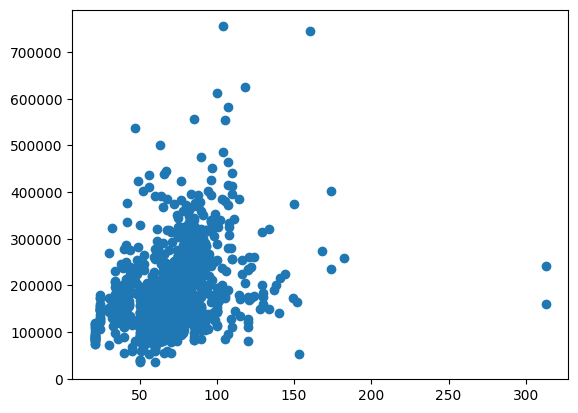

In [7]:
plt.scatter(x ='LotFrontage',y='SalePrice', data = train_data)

In [8]:
train_data.query('LotFrontage > 300')
#Drop 935,1299

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
934,935,20,RL,313.0,27650,Pave,NaN,IR2,HLS,AllPub,...,0,NaN,NaN,NaN,0,11,2008,WD,Normal,242000
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


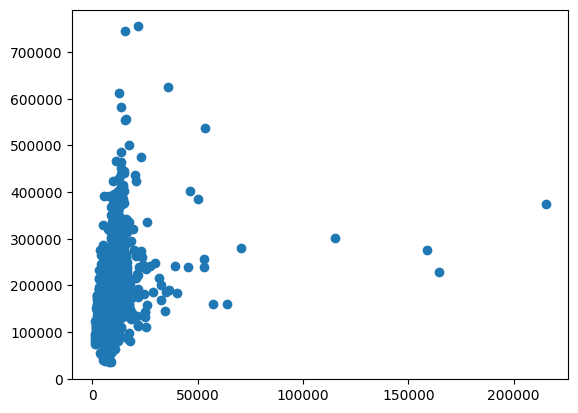

In [9]:
plt.scatter(x ='LotArea',y='SalePrice', data = train_data)

In [10]:
train_data.query("LotArea > 55000")
# 250,314,336,452,707
#maybe 1397 

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
249,250,50,RL,NaN,159000,Pave,NaN,IR2,Low,AllPub,...,0,NaN,NaN,Shed,500,6,2007,WD,Normal,277000
313,314,20,RL,150.0,215245,Pave,NaN,IR3,Low,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,375000
335,336,190,RL,NaN,164660,Grvl,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,Shed,700,8,2008,WD,Normal,228950
451,452,20,RL,62.0,70761,Pave,NaN,IR1,Low,AllPub,...,0,NaN,NaN,NaN,0,12,2006,WD,Normal,280000
706,707,20,RL,NaN,115149,Pave,NaN,IR2,Low,AllPub,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,302000
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
1396,1397,20,RL,NaN,57200,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,160000


In [11]:
z_scores = stats.zscore(train_data['LotArea'])
z_series = pd.Series(z_scores, index=train_data.index)
z_series.sort_values().tail(10)


384      4.268474
457      4.280500
769      4.308262
1396     4.678682
1298     5.348867
451      6.037793
706     10.486449
249     14.881285
335     15.448542
313     20.518273
dtype: float64

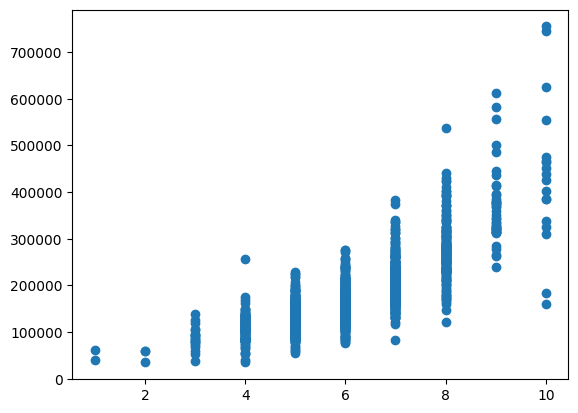

In [12]:
plt.scatter(x ='OverallQual',y='SalePrice', data = train_data)

In [13]:
train_data.query('OverallQual == 10')
#MAYBE 524

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
58,59,60,RL,66.0,13682,Pave,NaN,IR2,HLS,AllPub,...,0,NaN,NaN,NaN,0,10,2006,New,Partial,438780
185,186,75,RM,90.0,22950,Pave,NaN,IR2,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,475000
224,225,20,RL,103.0,13472,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,386250
389,390,60,RL,96.0,12474,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2008,New,Partial,426000
440,441,20,RL,105.0,15431,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,555000
515,516,20,RL,94.0,12220,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2009,New,Partial,402861
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
583,584,75,RM,75.0,13500,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,325000
591,592,60,RL,97.0,13478,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2009,ConLI,Normal,451950
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000


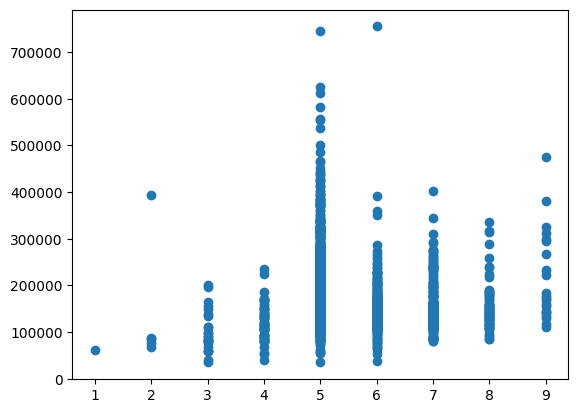

In [14]:
plt.scatter(x ='OverallCond',y='SalePrice', data = train_data)

In [15]:
train_data.query('OverallCond == 2')
#DROP 379

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
88,89,50,C (all),105.0,8470,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,10,2009,ConLD,Abnorml,85000
250,251,30,RL,55.0,5350,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,GdWo,Shed,450,5,2010,WD,Normal,76500
378,379,20,RL,88.0,11394,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,New,Partial,394432
398,399,30,RM,60.0,8967,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,11,2007,WD,Abnorml,67000
676,677,70,RM,60.0,9600,Pave,Grvl,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2006,WD,Normal,87000


In [16]:
train_data.query('OverallCond == 5 & SalePrice > 700000')
#1183

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,...,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000


In [17]:
train_data.query('OverallCond == 6 & SalePrice > 700000')
#692

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000


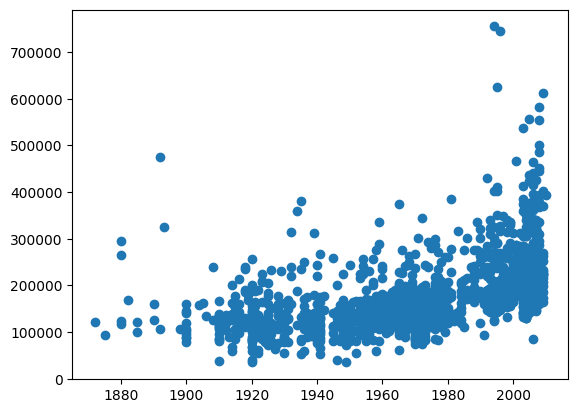

In [18]:
plt.scatter(x ='YearBuilt',y='SalePrice', data = train_data)

In [19]:
train_data.query("YearBuilt < 1900 & SalePrice > 400000")
#186 

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
185,186,75,RM,90.0,22950,Pave,NaN,IR2,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,475000


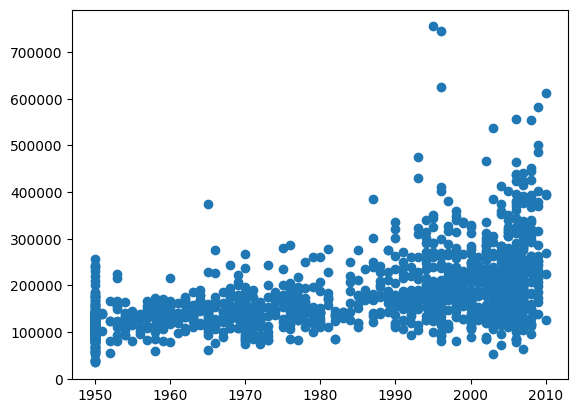

In [20]:
plt.scatter(x ='YearRemodAdd',y='SalePrice', data = train_data)

In [21]:
train_data.query("YearRemodAdd < 1970 & SalePrice > 300000")
#314

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
313,314,20,RL,150.0,215245,Pave,NaN,IR3,Low,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,375000


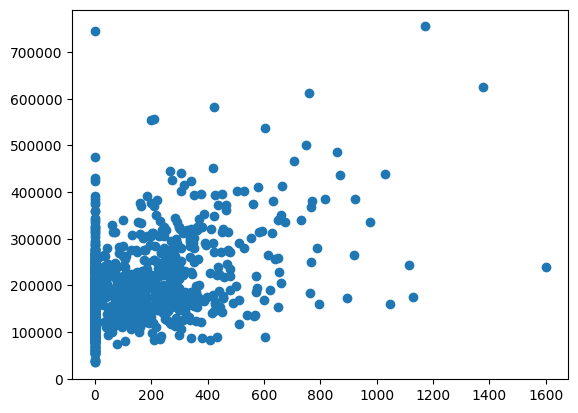

In [22]:
plt.scatter(x ='MasVnrArea',y='SalePrice', data = train_data)

In [23]:
train_data.query("MasVnrArea > 1400")
#298

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
297,298,60,FV,66.0,7399,Pave,Pave,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,239000


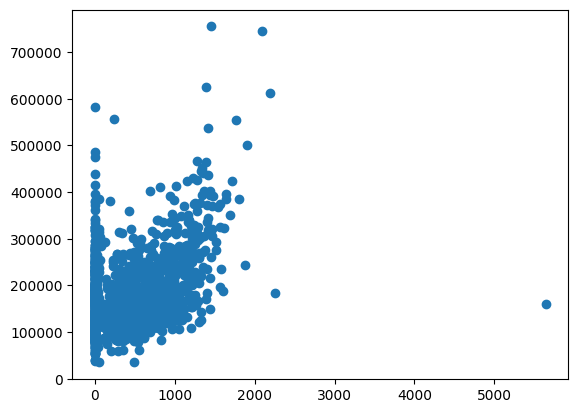

In [24]:
plt.scatter(x ='BsmtFinSF1',y='SalePrice', data = train_data)

In [25]:
train_data.query("BsmtFinSF1 > 5000")
#1299

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


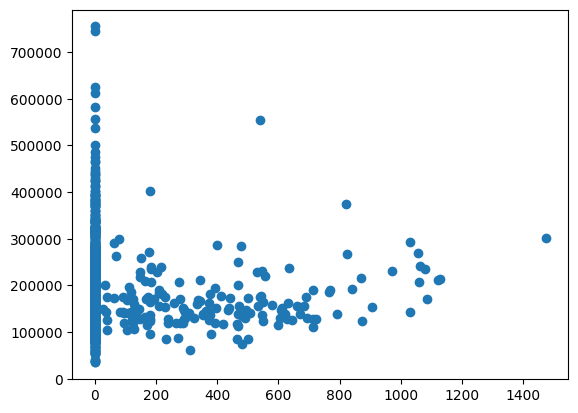

In [26]:
plt.scatter(x ='BsmtFinSF2',y='SalePrice', data = train_data)

In [27]:
train_data.query('BsmtFinSF2 > 400 & SalePrice > 500000')
#441

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
440,441,20,RL,105.0,15431,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,555000


In [28]:
train_data.query('BsmtFinSF2 > 1200')
#323
#by me

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
322,323,60,RL,86.0,10380,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,8,2007,WD,Normal,301000


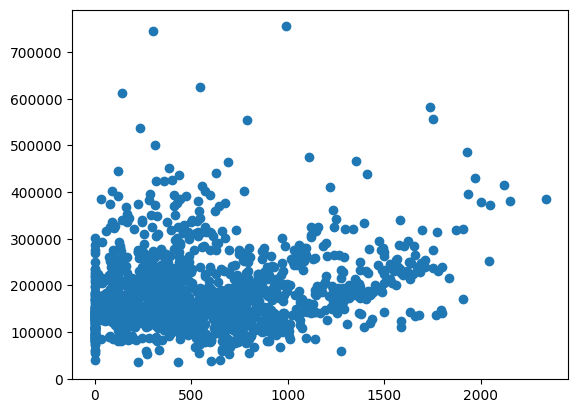

In [29]:
plt.scatter(x ='BsmtUnfSF',y='SalePrice', data = train_data)


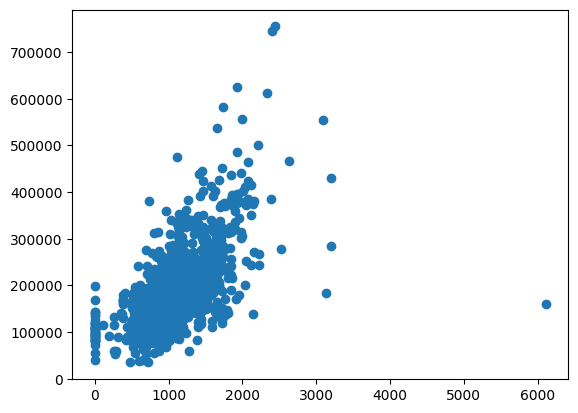

In [30]:
plt.scatter(x ='TotalBsmtSF',y='SalePrice', data = train_data)


In [31]:
train_data.query('TotalBsmtSF > 6000')
#1299

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


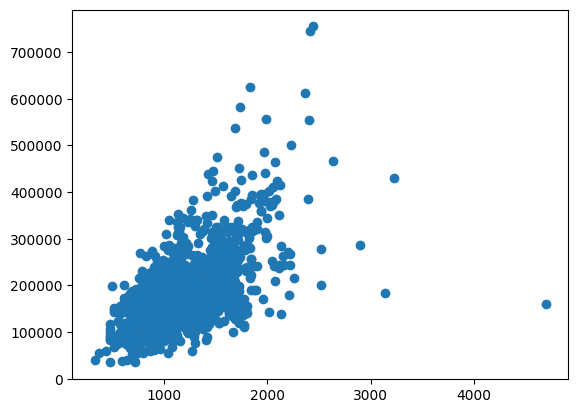

In [32]:
plt.scatter(x ='1stFlrSF',y='SalePrice', data = train_data)


In [33]:
train_data.query('TotalBsmtSF > 4000')
#1299

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


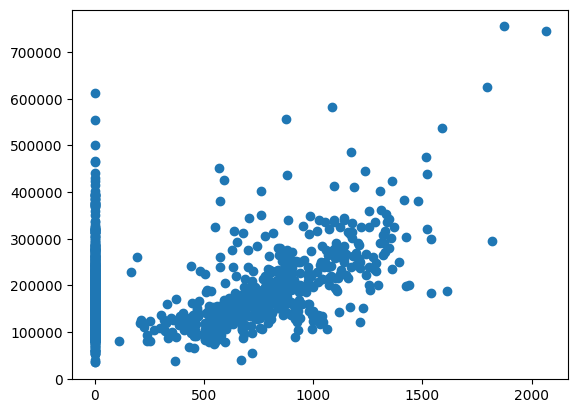

In [34]:
plt.scatter(x ='2ndFlrSF',y='SalePrice', data = train_data)


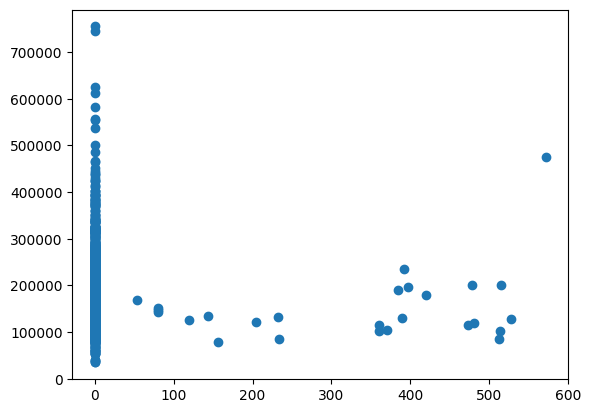

In [35]:
plt.scatter(x ='LowQualFinSF',y='SalePrice', data = train_data)


In [36]:
train_data.query('LowQualFinSF > 550')
#186

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
185,186,75,RM,90.0,22950,Pave,NaN,IR2,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,475000


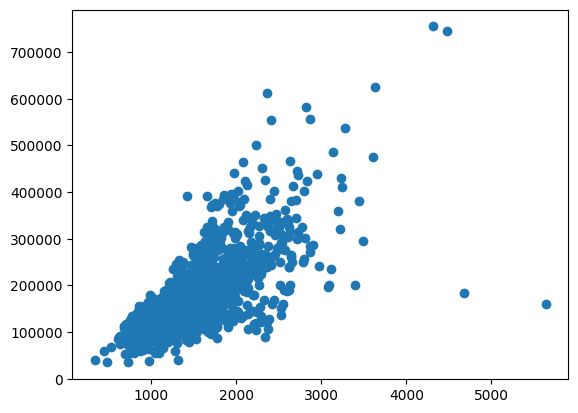

In [37]:
plt.scatter(x ='GrLivArea',y='SalePrice', data = train_data)


In [38]:
train_data.query('GrLivArea > 4500')
# 524,1299

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


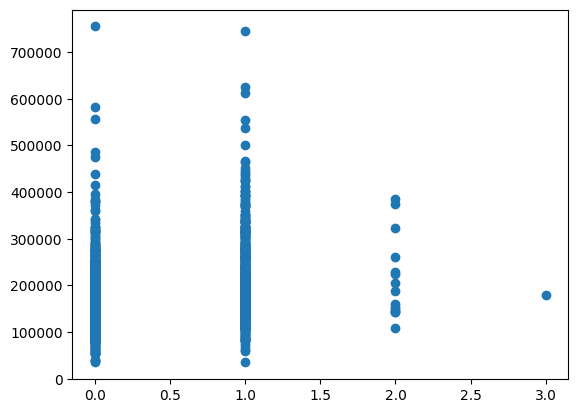

In [39]:
plt.scatter(x ='BsmtFullBath',y='SalePrice', data = train_data)


In [40]:
train_data.query('BsmtFullBath > 2.5')
#739

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
738,739,90,RL,60.0,10800,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2009,WD,Alloca,179000


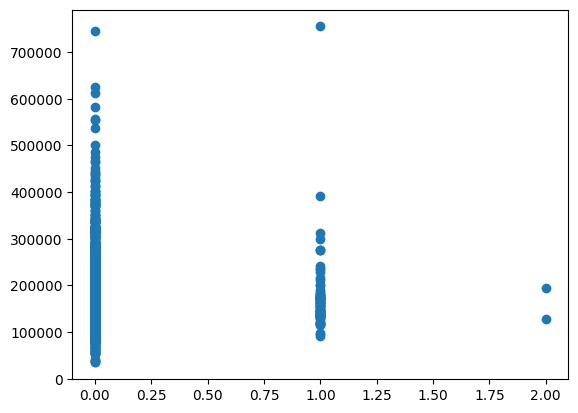

In [41]:
plt.scatter(x ='BsmtHalfBath',y='SalePrice', data = train_data)


In [42]:
train_data.query('BsmtHalfBath == 2')
# 598,955

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
597,598,120,RL,53.0,3922,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2007,New,Partial,194201
954,955,90,RL,35.0,9400,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,10,2006,WD,AdjLand,127500


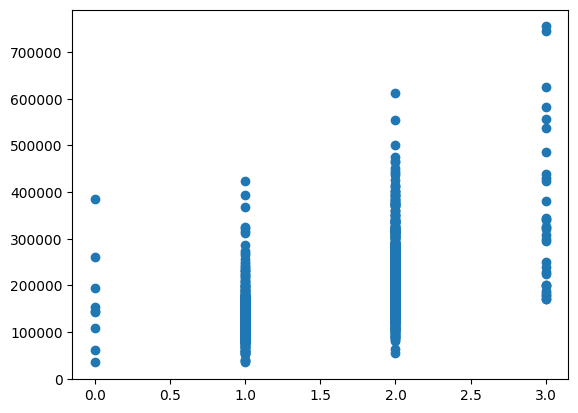

In [43]:
plt.scatter(x ='FullBath',y='SalePrice', data = train_data)


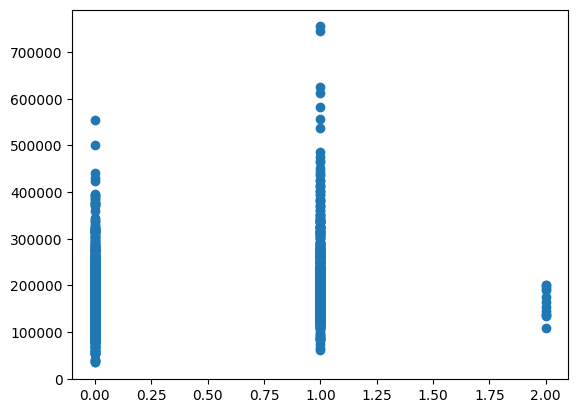

In [44]:
plt.scatter(x ='HalfBath',y='SalePrice', data = train_data)


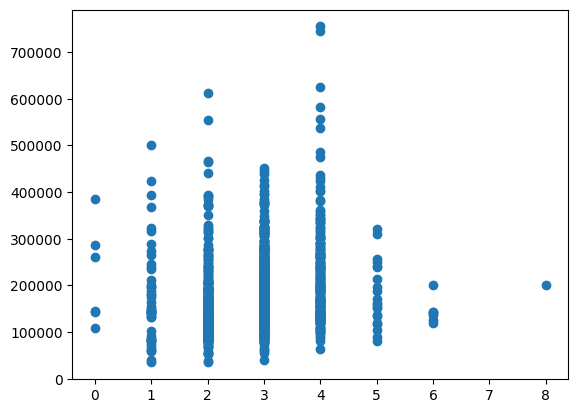

In [45]:
plt.scatter(x ='BedroomAbvGr',y='SalePrice', data = train_data)


In [46]:
train_data.query('BedroomAbvGr == 8')
#636

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
635,636,190,RH,60.0,10896,Pave,Pave,Reg,Bnk,AllPub,...,0,NaN,NaN,NaN,0,3,2007,WD,Abnorml,200000


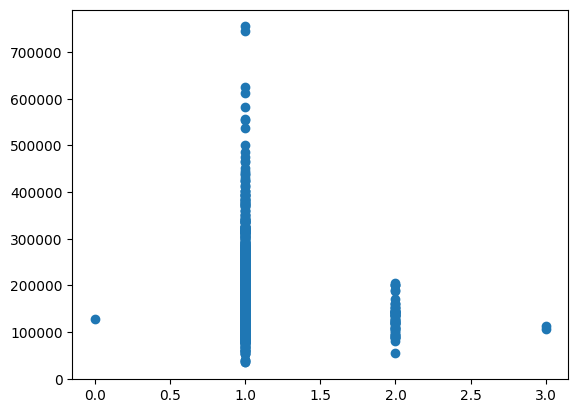

In [47]:
plt.scatter(x ='KitchenAbvGr',y='SalePrice', data = train_data)


In [48]:
train_data.query('KitchenAbvGr == 3')
#49,810

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
48,49,190,RM,33.0,4456,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2009,New,Partial,113000
809,810,75,RM,90.0,8100,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,11,2009,WD,Normal,106000


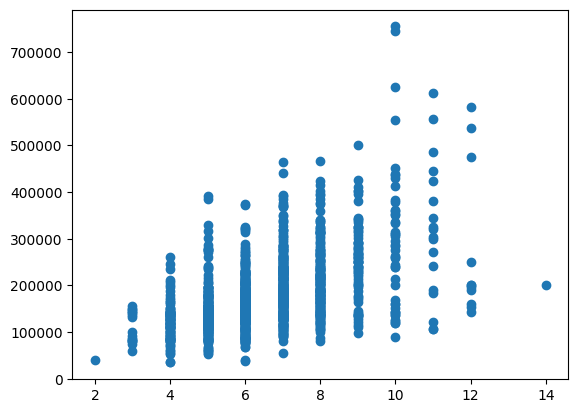

In [49]:
plt.scatter(x ='TotRmsAbvGrd',y='SalePrice', data = train_data)


In [50]:
train_data.query('TotRmsAbvGrd == 14')
#636

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
635,636,190,RH,60.0,10896,Pave,Pave,Reg,Bnk,AllPub,...,0,NaN,NaN,NaN,0,3,2007,WD,Abnorml,200000


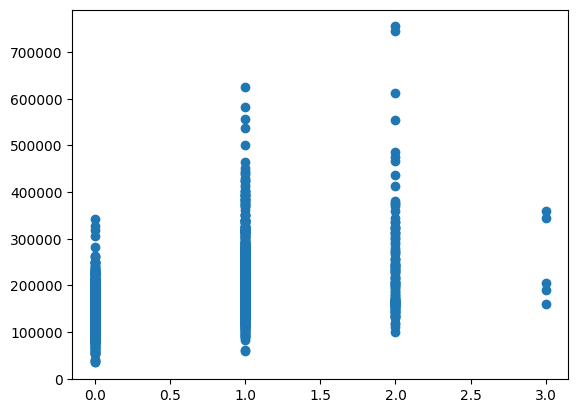

In [51]:
plt.scatter(x ='Fireplaces',y='SalePrice', data = train_data)

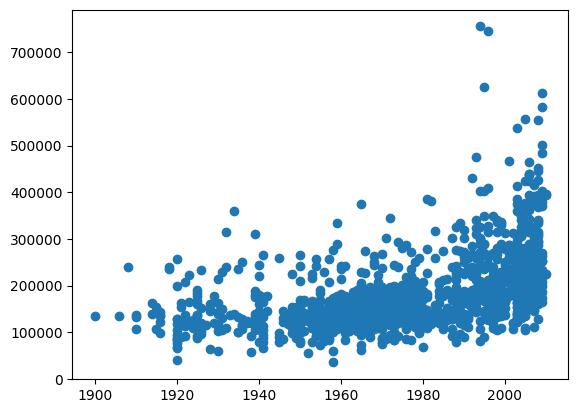

In [52]:
plt.scatter(x ='GarageYrBlt',y='SalePrice', data = train_data)

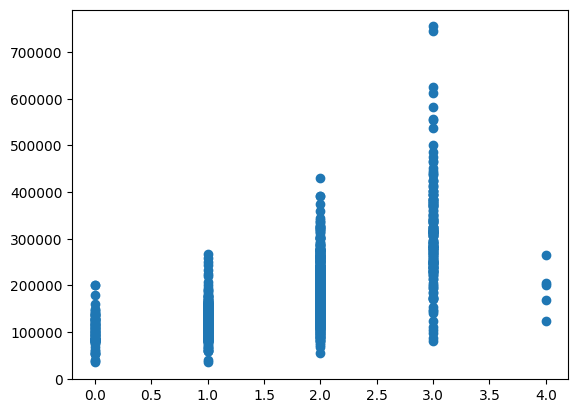

In [53]:
plt.scatter(x ='GarageCars',y='SalePrice', data = train_data)

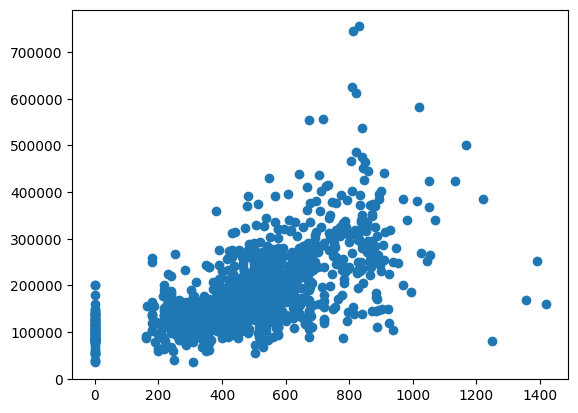

In [54]:
plt.scatter(x ='GarageArea',y='SalePrice', data = train_data)

In [55]:
train_data.query('GarageArea > 1200')
#1062,1191

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
581,582,20,RL,98.0,12704,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2009,New,Partial,253293
825,826,20,RL,114.0,14803,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,New,Partial,385000
1061,1062,30,C (all),120.0,18000,Grvl,NaN,Reg,Low,AllPub,...,0,NaN,NaN,Shed,560,8,2008,ConLD,Normal,81000
1190,1191,190,RL,NaN,32463,Pave,NaN,Reg,Low,AllPub,...,0,NaN,NaN,NaN,0,3,2007,WD,Normal,168000
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


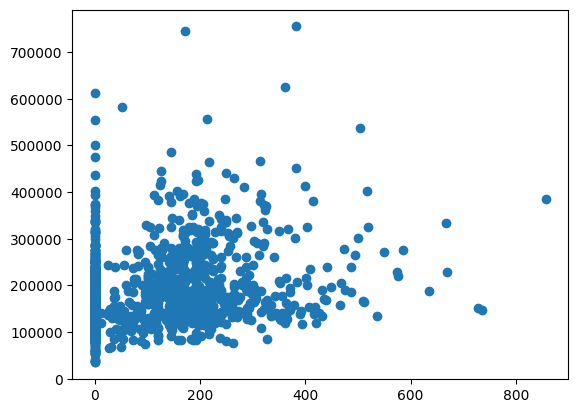

In [56]:
plt.scatter(x ='WoodDeckSF',y='SalePrice', data = train_data)

In [57]:
train_data.query('WoodDeckSF > 800')
#54
#by me


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
53,54,20,RL,68.0,50271,Pave,NaN,IR1,Low,AllPub,...,0,NaN,NaN,NaN,0,11,2006,WD,Normal,385000


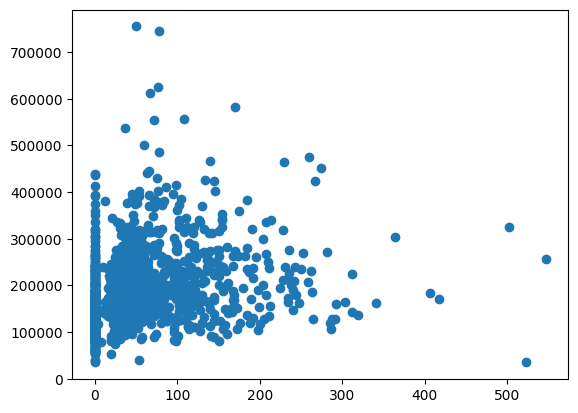

In [58]:
plt.scatter(x ='OpenPorchSF',y='SalePrice', data = train_data)

In [59]:
train_data.query('OpenPorchSF > 500')
#496


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
495,496,30,C (all),60.0,7879,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdWo,NaN,0,11,2009,WD,Abnorml,34900
583,584,75,RM,75.0,13500,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,325000
1328,1329,50,RM,60.0,10440,Pave,Grvl,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,1150,6,2008,WD,Normal,256000


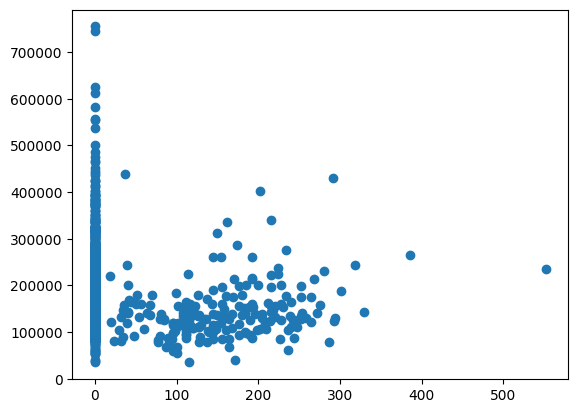

In [60]:
plt.scatter(x ='EnclosedPorch',y='SalePrice', data = train_data)

In [61]:
train_data.query('EnclosedPorch > 500')
#198


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
197,198,75,RL,174.0,25419,Pave,NaN,Reg,Lvl,AllPub,...,512,Ex,GdPrv,NaN,0,3,2006,WD,Abnorml,235000


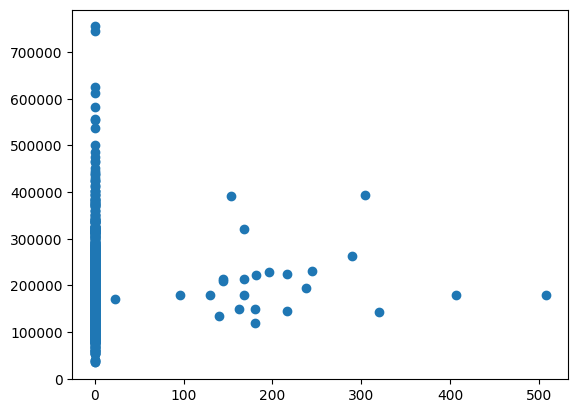

In [62]:
plt.scatter(x ='3SsnPorch',y='SalePrice', data = train_data)

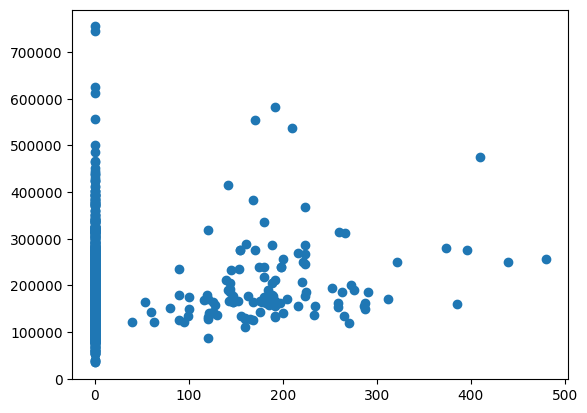

In [63]:
plt.scatter(x ='ScreenPorch',y='SalePrice', data = train_data)

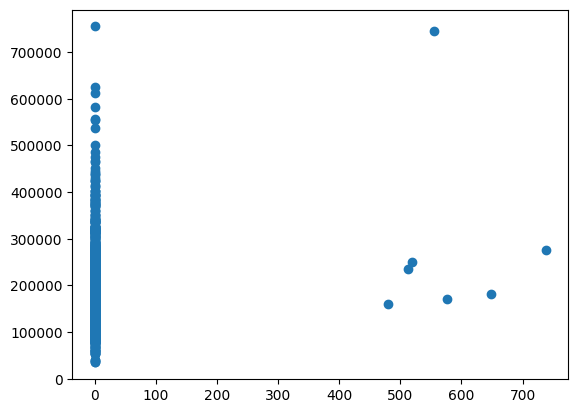

In [64]:
plt.scatter(x ='PoolArea',y='SalePrice', data = train_data)

In [65]:
values = [598,955,935,1299,250,314,336,707,379,1183,692,186,441,186,524,739,598,955,1062,1191,496,198,636,910,49]

In [66]:
train_data = train_data[train_data.Id.isin(values) == False]

In [67]:
pd.DataFrame(train_data.isnull().sum().sort_values(ascending=False)).head(20)

,0
PoolQC,1434
MiscFeature,1387
Alley,1348
Fence,1161
MasVnrType,860
FireplaceQu,684
LotFrontage,255
GarageYrBlt,76
GarageCond,76
GarageType,76


In [68]:
train_data['MiscFeature'].unique()

array([nan, 'Shed', 'Gar2', 'Othr', 'TenC'], dtype=object)

In [69]:
train_data['Alley'].unique()

array([nan, 'Grvl', 'Pave'], dtype=object)

In [70]:
train_data['Alley'] = train_data['Alley'].fillna('No')
test_data['Alley'] = test_data['Alley'].fillna('No')


/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


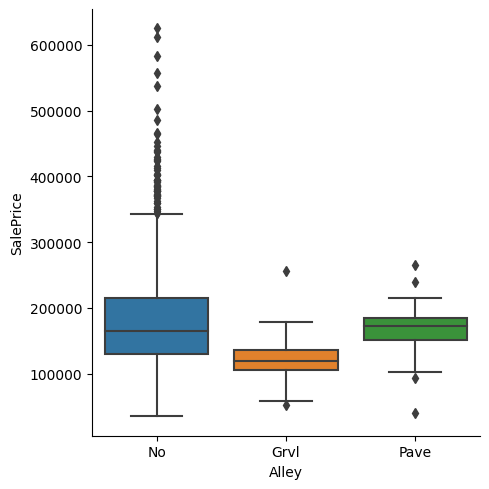

In [71]:
sns.catplot(data=train_data, x="Alley",y="SalePrice",kind="box")

In [72]:
train_data['Fence'] = train_data['Fence'].fillna('No')
test_data['Fence'] = test_data['Fence'].fillna('No')


/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


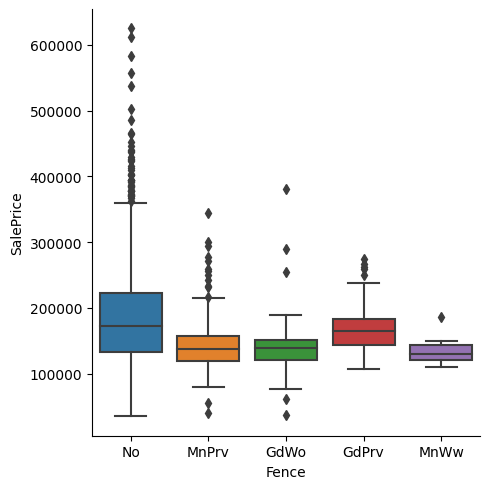

In [73]:
sns.catplot(data=train_data, x="Fence",y="SalePrice",kind="box")

In [74]:
train_data['MasVnrType'].unique()

array(['BrkFace', nan, 'Stone', 'BrkCmn'], dtype=object)

In [75]:
train_data['MasVnrType'] = train_data['MasVnrType'].fillna('No')
test_data['MasVnrType'] = test_data['MasVnrType'].fillna('No')


/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


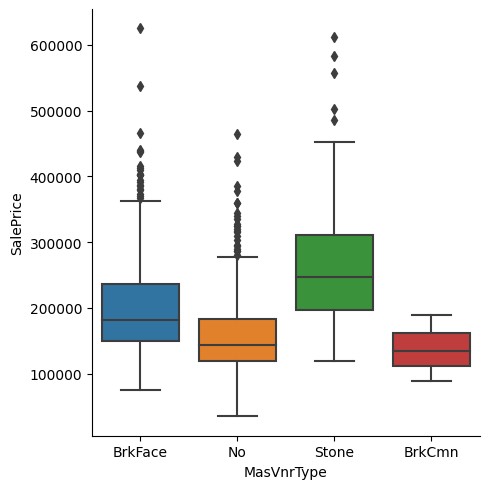

In [76]:
sns.catplot(data=train_data, x="MasVnrType",y="SalePrice",kind="box")

In [77]:
train_data['FireplaceQu'] = train_data['FireplaceQu'].fillna('No')
test_data['FireplaceQu'] = test_data['FireplaceQu'].fillna('No')


/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


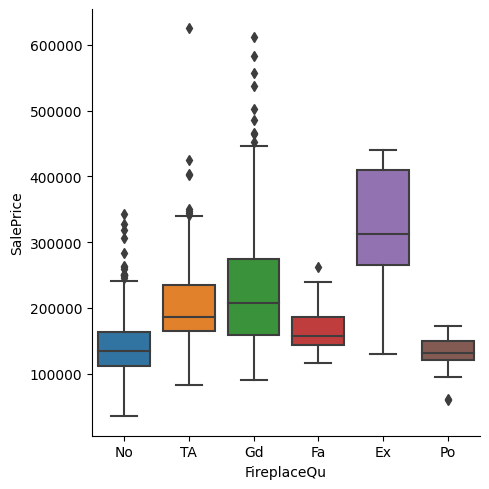

In [78]:
sns.catplot(data=train_data, x="FireplaceQu",y="SalePrice",kind="box")

In [79]:
train_data['LotFrontage'] = train_data['LotFrontage'].fillna(0)
test_data['LotFrontage'] = test_data['LotFrontage'].fillna(0)


In [80]:
train_data['GarageYrBlt'].corr(train_data['YearBuilt'])

0.8288350759381743

In [81]:
train_data['GarageCond'].unique()

array(['TA', 'Fa', nan, 'Gd', 'Po', 'Ex'], dtype=object)

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


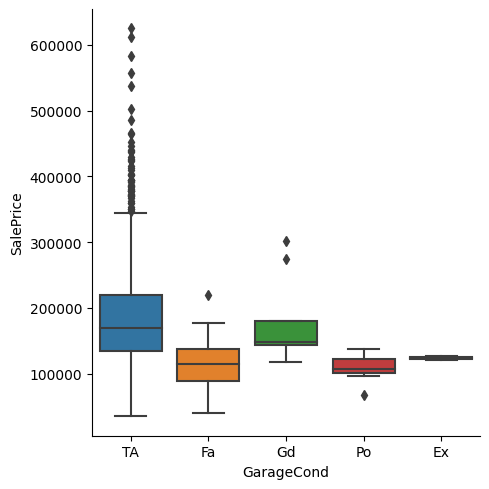

In [82]:
sns.catplot(data=train_data, x="GarageCond",y="SalePrice",kind="box")

In [83]:
train_data['GarageType'] = train_data['GarageType'].fillna('No')
test_data['GarageType'] = test_data['GarageType'].fillna('No')

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


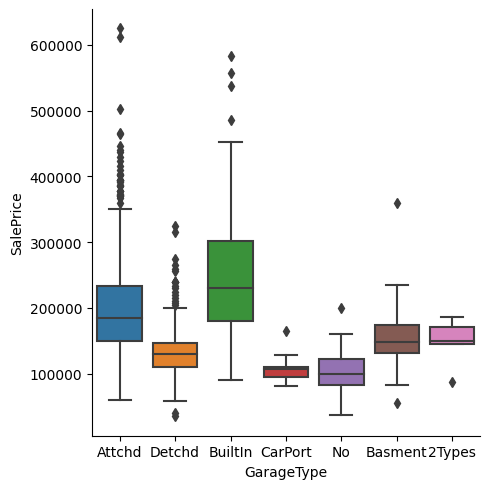

In [84]:
sns.catplot(data=train_data, x="GarageType",y="SalePrice",kind="box")

In [85]:
train_data['GarageFinish'] = train_data['GarageFinish'].fillna('No')
test_data['GarageFinish'] = test_data['GarageFinish'].fillna('No')

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


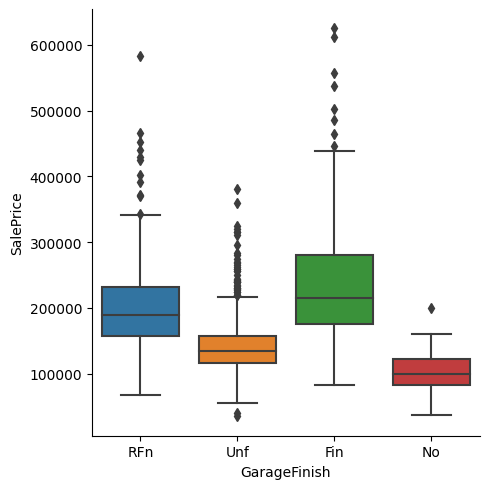

In [86]:
sns.catplot(data=train_data, x="GarageFinish",y="SalePrice",kind="box")

In [87]:
train_data['GarageQual'] = train_data['GarageQual'].fillna('No')
test_data['GarageQual'] = test_data['GarageQual'].fillna('No')

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


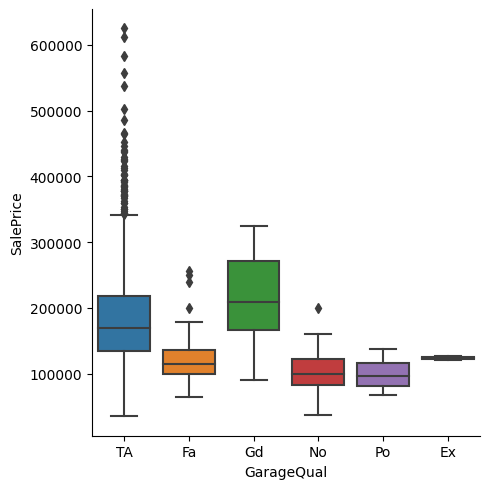

In [88]:
sns.catplot(data=train_data, x="GarageQual",y="SalePrice",kind="box")

In [89]:
train_data['BsmtFinType2'].unique()

array(['Unf', 'BLQ', nan, 'ALQ', 'Rec', 'LwQ', 'GLQ'], dtype=object)

In [90]:
train_data['BsmtFinType2'] = train_data['BsmtFinType2'].fillna('Unf')
test_data['BsmtFinType2'] = test_data['BsmtFinType2'].fillna('Unf')

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


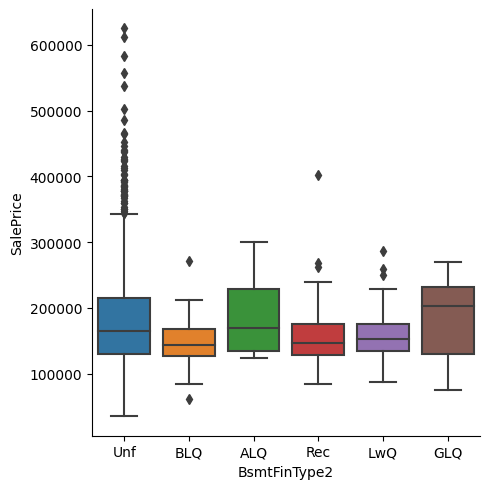

In [91]:
sns.catplot(data=train_data, x="BsmtFinType2",y="SalePrice",kind="box")

In [92]:
train_data['BsmtExposure'].unique()

array(['No', 'Gd', 'Mn', 'Av', nan], dtype=object)

In [93]:
train_data['BsmtExposure'] = train_data['BsmtExposure'].fillna('No')
test_data['BsmtExposure'] = test_data['BsmtExposure'].fillna('No')

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


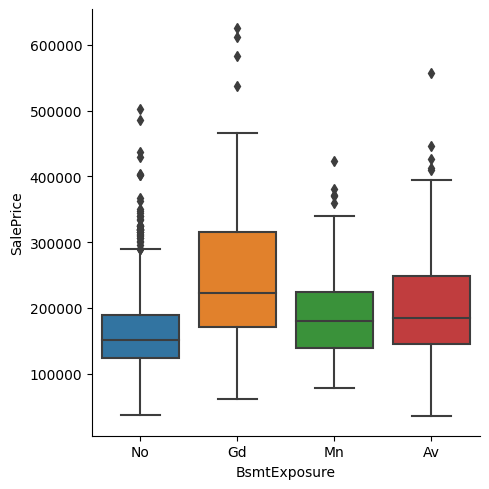

In [94]:
sns.catplot(data=train_data, x="BsmtExposure",y="SalePrice",kind="box")

In [95]:
train_data['BsmtQual'].unique()

array(['Gd', 'TA', 'Ex', nan, 'Fa'], dtype=object)

In [96]:
train_data['BsmtQual'] = train_data['BsmtQual'].fillna('No')
test_data['BsmtQual'] = test_data['BsmtQual'].fillna('No')

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


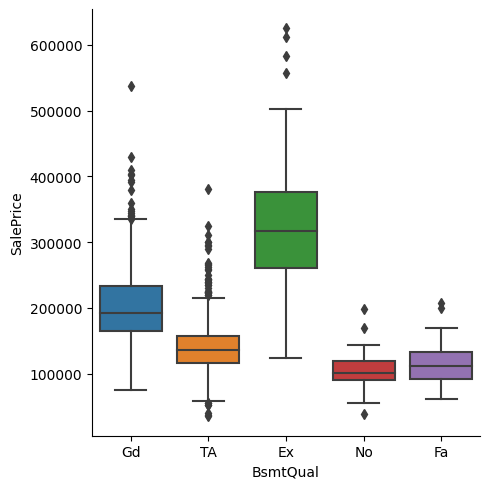

In [97]:
sns.catplot(data=train_data, x="BsmtQual",y="SalePrice",kind="box")

In [98]:
train_data['BsmtCond'].unique()

array(['TA', 'Gd', nan, 'Fa', 'Po'], dtype=object)

In [99]:
train_data['BsmtCond'] = train_data['BsmtCond'].fillna('No')
test_data['BsmtCond'] = test_data['BsmtCond'].fillna('No')

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


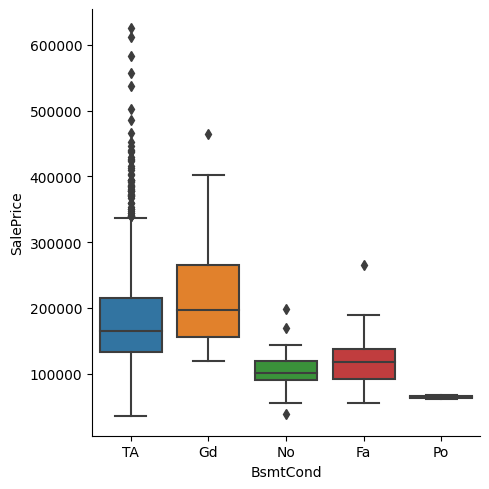

In [100]:
sns.catplot(data=train_data, x="BsmtCond",y="SalePrice",kind="box")

In [101]:
train_data['BsmtFinType1'].unique()

array(['GLQ', 'ALQ', 'Unf', 'Rec', 'BLQ', nan, 'LwQ'], dtype=object)

In [102]:
train_data['BsmtFinType1'] = train_data['BsmtFinType1'].fillna('Unf')
test_data['BsmtFinType1'] = test_data['BsmtFinType1'].fillna('Unf')

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


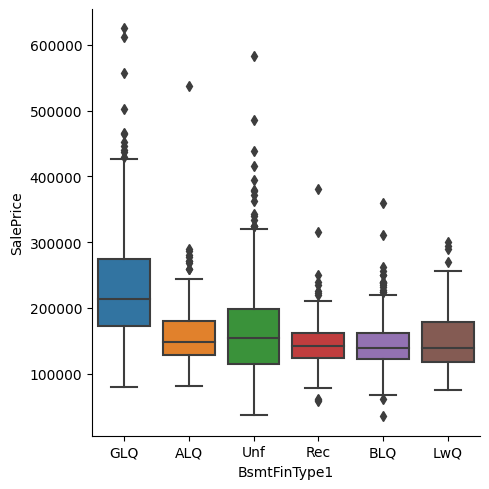

In [103]:
sns.catplot(data=train_data, x="BsmtFinType1",y="SalePrice",kind="box")

In [104]:
train_data['MasVnrArea'] = train_data['MasVnrArea'].fillna(0)
test_data['MasVnrArea'] = test_data['MasVnrArea'].fillna(0)

In [105]:
train_data['Electrical'] = train_data['Electrical'].fillna('SBrkr')
test_data['Electrical'] = test_data['Electrical'].fillna('SBrkr')

In [106]:
train_data = train_data.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'GarageYrBlt', 'GarageCond', 'BsmtFinType2'])
test_data = test_data.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'GarageYrBlt', 'GarageCond', 'BsmtFinType2'])

In [107]:
#feature engineering

In [108]:
train_data['houseage'] = train_data['YrSold'] - train_data['YearBuilt']
test_data['houseage'] = test_data['YrSold'] - test_data['YearBuilt']

In [109]:
train_data['houseremodelage'] = train_data['YrSold'] - train_data['YearRemodAdd']
test_data['houseremodelage'] = test_data['YrSold'] - test_data['YearRemodAdd']

In [110]:
train_data['totalsf'] = train_data['1stFlrSF'] + train_data['2ndFlrSF'] + train_data['BsmtFinSF1'] + train_data['BsmtFinSF2']
test_data['totalsf'] = test_data['1stFlrSF'] + test_data['2ndFlrSF'] + test_data['BsmtFinSF1'] + test_data['BsmtFinSF2']

In [111]:
train_data['totalarea'] = train_data['GrLivArea'] + train_data['TotalBsmtSF']
test_data['totalarea'] = test_data['GrLivArea'] + test_data['TotalBsmtSF']

In [112]:
train_data['totalbaths'] = train_data['BsmtFullBath'] + train_data['FullBath'] + 0.5 * (train_data['BsmtHalfBath'] + train_data['HalfBath']) 
test_data['totalbaths'] = test_data['BsmtFullBath'] + test_data['FullBath'] + 0.5 * (test_data['BsmtHalfBath'] + test_data['HalfBath']) 

In [113]:
train_data['totalporchsf'] = train_data['OpenPorchSF'] + train_data['3SsnPorch'] + train_data['EnclosedPorch'] + train_data['ScreenPorch'] + train_data['WoodDeckSF']
test_data['totalporchsf'] = test_data['OpenPorchSF'] + test_data['3SsnPorch'] + test_data['EnclosedPorch'] + test_data['ScreenPorch'] + test_data['WoodDeckSF']

In [114]:
train_data = train_data.drop(columns=['Id','YrSold', 'YearBuilt', 'YearRemodAdd','1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'GrLivArea', 'TotalBsmtSF','BsmtFullBath', 'FullBath', 'BsmtHalfBath', 'HalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch','WoodDeckSF'])
test_data = test_data.drop(columns=['YrSold', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'GrLivArea', 'TotalBsmtSF','BsmtFullBath', 'FullBath', 'BsmtHalfBath', 'HalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch','WoodDeckSF'])

<Axes: >

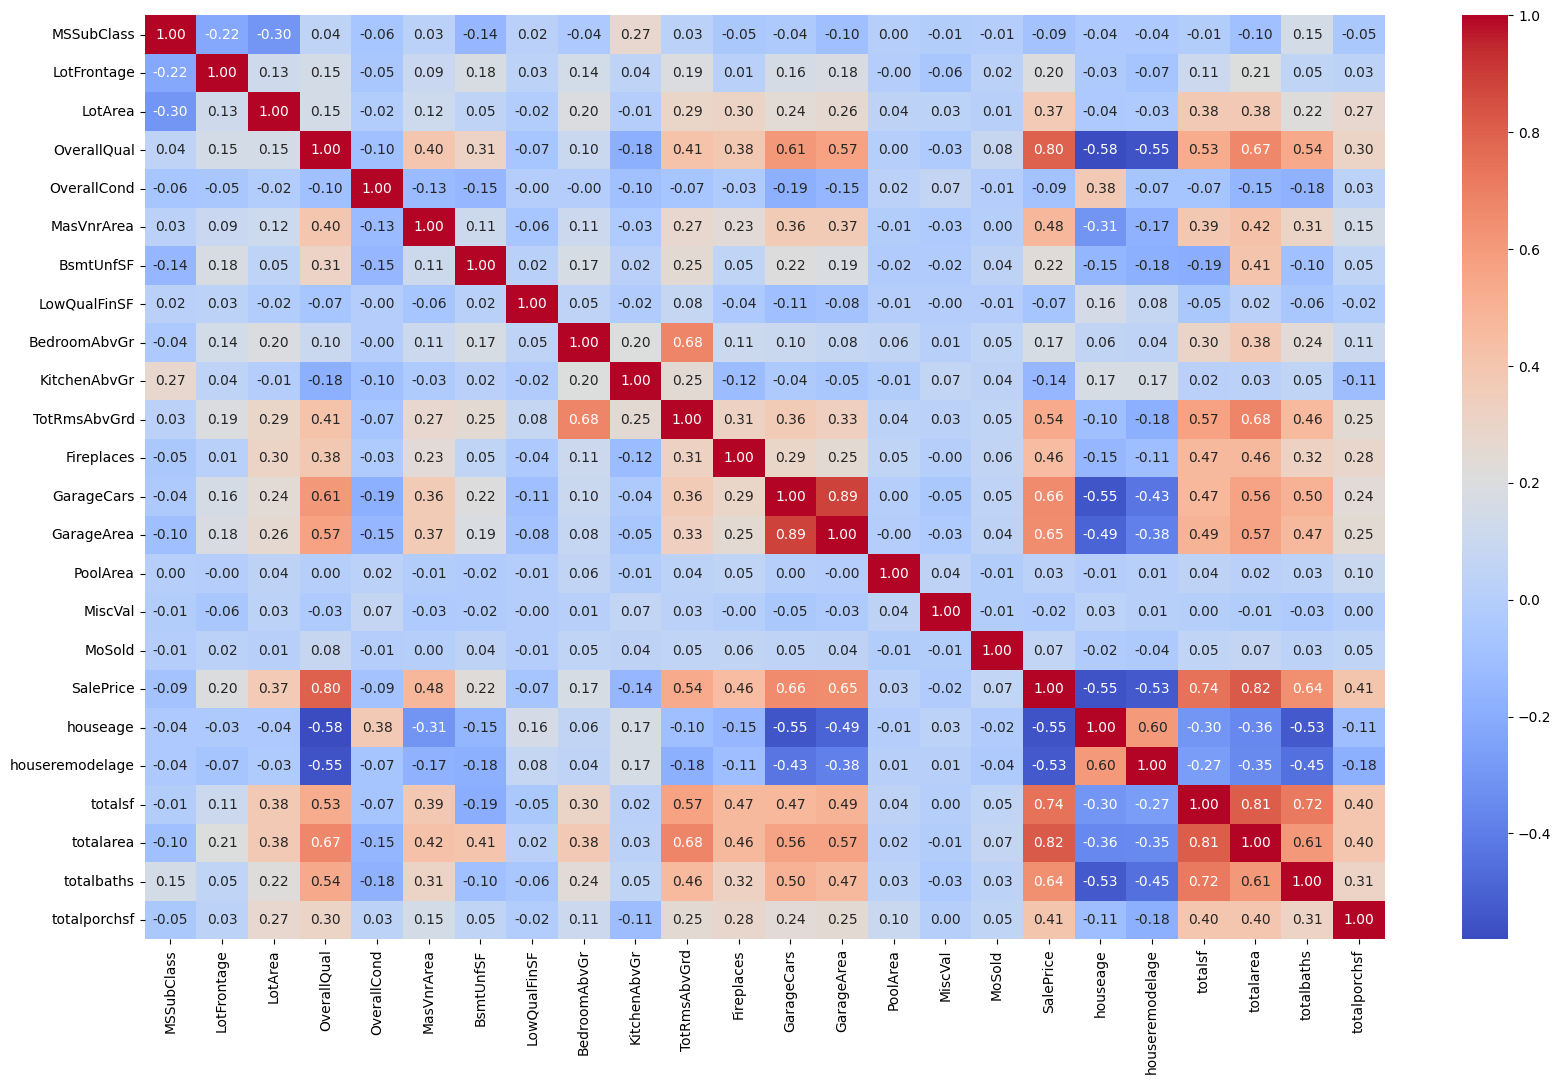

In [115]:
correlation_matrix = train_data.corr(numeric_only=True)
plt.figure(figsize=(20,12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

In [116]:
train_data = train_data.drop(columns=['GarageArea'])
test_data = test_data.drop(columns=['GarageArea'])


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='SalePrice', ylabel='Count'>

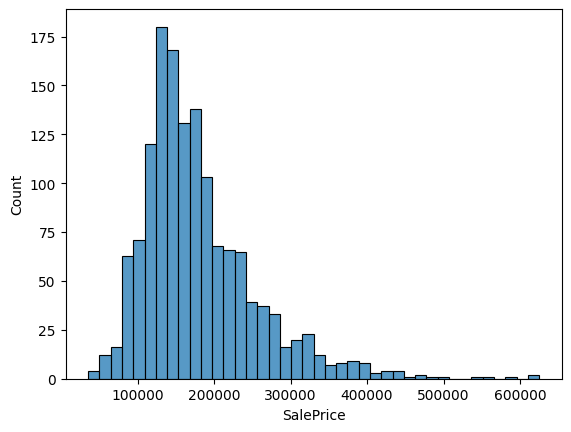

In [117]:
sns.histplot(
    train_data,
    x=train_data['SalePrice']
)

In [118]:
train_data['SalePrice'] = np.log1p(train_data['SalePrice'])


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='SalePrice', ylabel='Count'>

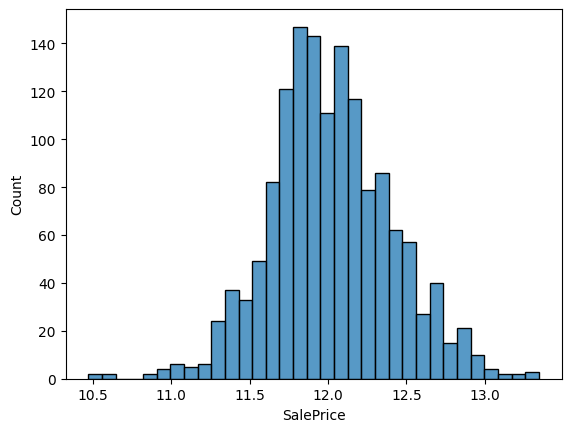

In [119]:
sns.histplot(
    train_data,
    x=train_data['SalePrice']
)

In [120]:
train_data.dtypes[train_data.dtypes=='object']


MSZoning         object
Street           object
LotShape         object
LandContour      object
Utilities        object
LotConfig        object
LandSlope        object
Neighborhood     object
Condition1       object
Condition2       object
BldgType         object
HouseStyle       object
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
ExterQual        object
ExterCond        object
Foundation       object
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
Heating          object
HeatingQC        object
CentralAir       object
Electrical       object
KitchenQual      object
Functional       object
FireplaceQu      object
GarageType       object
GarageFinish     object
GarageQual       object
PavedDrive       object
SaleType         object
SaleCondition    object
dtype: object

In [121]:
train_data.dtypes[train_data.dtypes !='object']
 

MSSubClass           int64
LotFrontage        float64
LotArea              int64
OverallQual          int64
OverallCond          int64
MasVnrArea         float64
BsmtUnfSF            int64
LowQualFinSF         int64
BedroomAbvGr         int64
KitchenAbvGr         int64
TotRmsAbvGrd         int64
Fireplaces           int64
GarageCars           int64
PoolArea             int64
MiscVal              int64
MoSold               int64
SalePrice          float64
houseage             int64
houseremodelage      int64
totalsf              int64
totalarea            int64
totalbaths         float64
totalporchsf         int64
dtype: object

In [122]:
ode_cols = ['LotShape', 'LandContour','Utilities','LandSlope',  'BsmtQual',  'BsmtFinType1',  'CentralAir',  'Functional','FireplaceQu', 'GarageFinish', 'GarageQual', 'PavedDrive', 'ExterCond', 'KitchenQual', 'BsmtExposure', 'HeatingQC','ExterQual', 'BsmtCond']


In [123]:
ohe_cols = ['Street', 'LotConfig','Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd','MasVnrType','Foundation',  'Electrical',  'SaleType', 'MSZoning', 'SaleCondition', 'Heating', 'GarageType', 'RoofMatl']

In [124]:
num_cols = train_data.select_dtypes(include=['int64', 'float64']).columns
num_cols = num_cols.drop('SalePrice')

In [125]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [126]:
ode_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

In [127]:
ohe_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [128]:
col_trans = ColumnTransformer(transformers=[
    ('num_p', num_pipeline, num_cols),
    ('ode_p', ode_pipeline, ode_cols),
    ('ohe_p', ohe_pipeline, ohe_cols),
    ],
    remainder='passthrough', 
    n_jobs=-1)

In [129]:
pipeline = Pipeline(steps=[
    ('preprocessing', col_trans)
])

In [130]:
X = train_data.drop('SalePrice', axis=1)
y = train_data['SalePrice']

In [131]:
X_preprocessed = pipeline.fit_transform(X)

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=25)

In [133]:
#build models
lr = LinearRegression()


In [134]:
lr.fit(X_train, y_train)


LinearRegression()

In [135]:
y_pred_lr = lr.predict(X_test)


In [136]:
mean_squared_error(y_test, y_pred_lr)

5906980106018094.0

In [137]:
RFR = RandomForestRegressor(random_state=13)

In [138]:
param_grid_RFR = {
    'max_depth': [5, 10, 15],
    'n_estimators': [100, 250, 500],
    'min_samples_split': [3, 5, 10]
}

In [139]:
rfr_cv = GridSearchCV(RFR, param_grid_RFR, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

In [140]:
rfr_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=13), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_split': [3, 5, 10],
                         'n_estimators': [100, 250, 500]},
             scoring='neg_mean_squared_error')

In [141]:
np.sqrt(-1 * rfr_cv.best_score_)


0.13158145245596525

In [142]:
rfr_cv.best_params_

{'max_depth': 15, 'min_samples_split': 3, 'n_estimators': 500}

In [143]:
XGB = XGBRegressor(random_state=13)

In [144]:
param_grid_XGB = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [300],
    'max_depth': [3],
    'min_child_weight': [1,2,3],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

In [145]:
xgb_cv = GridSearchCV(XGB, param_grid_XGB, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)


In [146]:
xgb_cv.fit(X_train, y_train)


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=13, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.05, 0.1, 0.2], 'max_depth': [3],
                         'min_child_weight': [1, 2, 3], 'n_estimators': [300],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='neg_mean_squared_error')

In [147]:
np.sqrt(-1 * xgb_cv.best_score_)


0.11828944383479657

In [148]:
ridge = Ridge()


In [149]:
param_grid_ridge = {
    'alpha': [0.05, 0.1, 1, 3, 5, 10],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag']
}

In [150]:
ridge_cv = GridSearchCV(ridge, param_grid_ridge, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

In [151]:
ridge_cv.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.05, 0.1, 1, 3, 5, 10],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                    'sparse_cg', 'sag']},
             scoring='neg_mean_squared_error')

In [152]:
np.sqrt(-1 * ridge_cv.best_score_)


0.11392461055108387

In [153]:
GBR = GradientBoostingRegressor()


In [154]:
param_grid_GBR = {
    'max_depth': [12, 15, 20],
    'n_estimators': [200, 300, 1000],
    'min_samples_leaf': [10, 25, 50],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_features': [0.01, 0.1, 0.7]
}

In [155]:
GBR_cv = GridSearchCV(GBR, param_grid_GBR, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

In [156]:
GBR_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [12, 15, 20],
                         'max_features': [0.01, 0.1, 0.7],
                         'min_samples_leaf': [10, 25, 50],
                         'n_estimators': [200, 300, 1000]},
             scoring='neg_mean_squared_error')

In [157]:
np.sqrt(-1 * GBR_cv.best_score_)

0.11419646299635637

In [158]:
lgbm_regressor = lgb.LGBMRegressor()


In [159]:
param_grid_lgbm = {
    'boosting_type': ['gbdt', 'dart'],
    'num_leaves': [20, 30, 40],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300]
}

In [160]:
lgbm_cv = GridSearchCV(lgbm_regressor, param_grid_lgbm, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)


In [161]:
lgbm_cv.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1818
[LightGBM] [Info] Number of data points in the train set: 767, number of used features: 104
[LightGBM] [Info] Start training from score 12.036915
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1816
[LightGBM] [Info] Number of data points in the train set: 766, number of used features: 104
[LightGBM] [Info] Start training from score 12.008286
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

GridSearchCV(cv=3, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'boosting_type': ['gbdt', 'dart'],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'n_estimators': [100, 200, 300],
                         'num_leaves': [20, 30, 40]},
             scoring='neg_mean_squared_error')

In [162]:
np.sqrt(-1 * lgbm_cv.best_score_)

0.12613084405004937

In [163]:
catboost = CatBoostRegressor(loss_function='RMSE', verbose=False)

In [164]:
param_grid_cat ={
    'iterations': [100, 500, 1000],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.5]
}

In [165]:
cat_cv = GridSearchCV(catboost, param_grid_cat, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

In [166]:
cat_cv.fit(X_train, y_train)



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x7cba105dfa50>,
             n_jobs=-1,
             param_grid={'depth': [4, 6, 8, 10], 'iterations': [100, 500, 1000],
                         'learning_rate': [0.01, 0.05, 0.1, 0.5]},
             scoring='neg_mean_squared_error')

In [167]:
np.sqrt(-1 * cat_cv.best_score_)

0.11724493657152948

In [168]:
vr = VotingRegressor([('gbr', GBR_cv.best_estimator_),
                      ('xgb', xgb_cv.best_estimator_),
                      ('ridge', ridge_cv.best_estimator_)],
                    weights=[2,3,1])

In [169]:
vr.fit(X_train, y_train)


VotingRegressor(estimators=[('gbr',
                             GradientBoostingRegressor(learning_rate=0.01,
                                                       max_depth=20,
                                                       max_features=0.1,
                                                       min_samples_leaf=10,
                                                       n_estimators=1000)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=0.9, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_m...
                                          interaction_constraints=None,
                                          learning_rate=0.1, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=3,
                                          max_leaves=None, min_child_weight=2,
                                          missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=300,
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=13, ...)),
                            ('ridge', Ridge(alpha=10, solver='sag'))],
                weights=[2, 3, 1])

In [170]:
y_pred_vr = vr.predict(X_test)


In [171]:
mean_squared_error(y_test, y_pred_vr, squared=False)


0.11650444398208185

In [172]:
estimators = [
    ('gbr', GBR_cv.best_estimator_),
    ('xgb', xgb_cv.best_estimator_),
    ('cat', cat_cv.best_estimator_),
    ('lgb', lgbm_cv.best_estimator_),
    ('rfr', rfr_cv.best_estimator_),
]

In [173]:
stackreg = StackingRegressor(
            estimators = estimators,
            final_estimator = vr
)

In [174]:
stackreg.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2000
[LightGBM] [Info] Number of data points in the train set: 1150, number of used features: 112
[LightGBM] [Info] Start training from score 12.023456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1887
[LightGBM] [Info] Number of data points in the train set: 920, number of used features: 106
[LightGBM] [Info] Start training from score 12.012334
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enou

StackingRegressor(estimators=[('gbr',
                               GradientBoostingRegressor(learning_rate=0.01,
                                                         max_depth=20,
                                                         max_features=0.1,
                                                         min_samples_leaf=10,
                                                         n_estimators=1000)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.9, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval...
                                                                            interaction_constraints=None,
                                                                            learning_rate=0.1,
                                                                            max_bin=None,
                                                                            max_cat_threshold=None,
                                                                            max_cat_to_onehot=None,
                                                                            max_delta_step=None,
                                                                            max_depth=3,
                                                                            max_leaves=None,
                                                                            min_child_weight=2,
                                                                            missing=nan,
                                                                            monotone_constraints=None,
                                                                            multi_strategy=None,
                                                                            n_estimators=300,
                                                                            n_jobs=None,
                                                                            num_parallel_tree=None,
                                                                            random_state=13, ...)),
                                                              ('ridge',
                                                               Ridge(alpha=10,
                                                                     solver='sag'))],
                                                  weights=[2, 3, 1]))

In [175]:
y_pred_stack = stackreg.predict(X_test)


In [176]:
mean_squared_error(y_test, y_pred_stack, squared=False)


0.12361427613114069

In [177]:
df_test_preprocess = pipeline.transform(test_data)


In [178]:
y_stacking = np.exp(stackreg.predict(df_test_preprocess))

df_y_stacking_out = test_data[['Id']]
df_y_stacking_out['SalePrice'] = y_stacking

df_y_stacking_out.to_csv('submission.csv', index=False)

/tmp/ipykernel_13/1103520992.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y_stacking_out['SalePrice'] = y_stacking


In [179]:
# print(train_data.shape)
# print(test_data.shape)

In [180]:
# print(train_data.isnull().sum().to_string())


In [181]:
# print(test_data.isnull().sum().to_string())

In [182]:
# test_data.info()

In [183]:
# # sns.heatmap(df.isnull(),yticklabels=False,cbar=False)
# sns.heatmap(train_data.isnull())

In [184]:
# sns.heatmap(test_data.isnull())

In [185]:
# print(train_data['MSZoning'].value_counts().sum())
# print(test_data['MSZoning'].value_counts().sum())

In [186]:
# test_data['MSZoning'] = test_data['MSZoning'].fillna(test_data['MSZoning'].mode()[0])

In [187]:
# # train_data[''] = train_data[''].fillna(train_data[''])
# # test_data[''] = test_data[''].fillna(test_data[''])
# test_data['LotFrontage'] = test_data['LotFrontage'].fillna(test_data['LotFrontage'].mean())
# train_data['LotFrontage'] = train_data['LotFrontage'].fillna(train_data['LotFrontage'].mean())


In [188]:
# train_data.drop(['Alley'], axis=1, inplace=True)
# test_data.drop(['Alley'], axis=1, inplace=True)

In [189]:
# train_data.drop(['MasVnrType'],axis=1,inplace=True)
# test_data.drop(['MasVnrType'],axis=1,inplace=True)

In [190]:
# test_data['LotFrontage'] = test_data['LotFrontage'].fillna(test_data['LotFrontage'].mean())
# train_data['LotFrontage'] = train_data['LotFrontage'].fillna(train_data['LotFrontage'].mean())


In [191]:
# train_data['BsmtCond'] = train_data['BsmtCond'].fillna(train_data['BsmtCond'].mode()[0])
# test_data['BsmtCond'] = test_data['BsmtCond'].fillna(test_data['BsmtCond'].mode()[0])

# train_data['BsmtQual'] = train_data['BsmtQual'].fillna(train_data['BsmtQual'].mode()[0])
# test_data['BsmtQual'] = test_data['BsmtQual'].fillna(test_data['BsmtQual'].mode()[0])



In [192]:
# train_data['FireplaceQu'] = train_data['FireplaceQu'].fillna(train_data['FireplaceQu'].mode()[0])
# test_data['FireplaceQu'] = test_data['FireplaceQu'].fillna(test_data['FireplaceQu'].mode()[0])

# train_data['GarageType'] = train_data['GarageType'].fillna(train_data['GarageType'].mode()[0])
# test_data['GarageType'] = test_data['GarageType'].fillna(test_data['GarageType'].mode()[0])


In [193]:
# train_data.drop(['PoolQC','Fence','MiscFeature'],axis=1,inplace=True)
# test_data.drop(['PoolQC','Fence','MiscFeature'],axis=1,inplace=True)

In [194]:
# train_data['BsmtExposure'] = train_data['BsmtExposure'].fillna(train_data['BsmtExposure'].mode()[0])
# test_data['BsmtExposure'] = test_data['BsmtExposure'].fillna(test_data['BsmtExposure'].mode()[0])

# train_data['BsmtFinType1'] = train_data['BsmtFinType1'].fillna(train_data['BsmtFinType1'].mode()[0])
# test_data['BsmtFinType1'] = test_data['BsmtFinType1'].fillna(test_data['BsmtFinType1'].mode()[0])

# train_data['BsmtFinType2'] = train_data['BsmtFinType2'].fillna(train_data['BsmtFinType2'].mode()[0])
# test_data['BsmtFinType2'] = test_data['BsmtFinType2'].fillna(test_data['BsmtFinType2'].mode()[0])



# train_data['GarageFinish'] = train_data['GarageFinish'].fillna(train_data['GarageFinish'].mode()[0])
# test_data['GarageFinish'] = test_data['GarageFinish'].fillna(test_data['GarageFinish'].mode()[0])

# train_data['GarageQual'] = train_data['GarageQual'].fillna(train_data['GarageQual'].mode()[0])
# test_data['GarageQual'] = test_data['GarageQual'].fillna(test_data['GarageQual'].mode()[0])


# train_data['GarageCond'] = train_data['GarageCond'].fillna(train_data['GarageCond'].mode()[0])
# test_data['GarageCond'] = test_data['GarageCond'].fillna(test_data['GarageCond'].mode()[0])


# train_data['Electrical'] = train_data['Electrical'].fillna(train_data['Electrical'].mode()[0])

# train_data['MasVnrArea'] = train_data['MasVnrArea'].fillna(train_data['MasVnrArea'].mean())



In [195]:
# test_data['Utilities'] = test_data['Utilities'].fillna(test_data['Utilities'].mode()[0])
# test_data['Exterior1st'] = test_data['Exterior1st'].fillna(test_data['Exterior1st'].mode()[0])
# test_data['Exterior2nd'] = test_data['Exterior2nd'].fillna(test_data['Exterior2nd'].mode()[0])
# test_data['KitchenQual'] = test_data['KitchenQual'].fillna(test_data['KitchenQual'].mode()[0])
# test_data['Functional'] = test_data['Functional'].fillna(test_data['Functional'].mode()[0])
# test_data['SaleType'] = test_data['SaleType'].fillna(test_data['SaleType'].mode()[0])



In [196]:
# test_data['MasVnrArea'] = test_data['MasVnrArea'].fillna(test_data['MasVnrArea'].mean())
# test_data['BsmtFinSF1'] = test_data['BsmtFinSF1'].fillna(test_data['BsmtFinSF1'].mean())
# test_data['BsmtFinSF2'] = test_data['BsmtFinSF2'].fillna(test_data['BsmtFinSF2'].mean())
# test_data['BsmtUnfSF'] = test_data['BsmtUnfSF'].fillna(test_data['BsmtUnfSF'].mean())
# test_data['TotalBsmtSF'] = test_data['TotalBsmtSF'].fillna(test_data['TotalBsmtSF'].mean())
# test_data['BsmtFullBath'] = test_data['BsmtFullBath'].fillna(test_data['BsmtFullBath'].mean())
# test_data['BsmtHalfBath'] = test_data['BsmtHalfBath'].fillna(test_data['BsmtHalfBath'].mean())
# test_data['GarageCars'] = test_data['GarageCars'].fillna(test_data['GarageCars'].mean())
# test_data['GarageArea'] = test_data['GarageArea'].fillna(test_data['GarageArea'].mean())



In [197]:
# train_data['GarageYrBlt'] = train_data['GarageYrBlt'].fillna(train_data['GarageYrBlt'].mean())
# test_data['GarageYrBlt'] = test_data['GarageYrBlt'].fillna(test_data['GarageYrBlt'].mean())



In [198]:
# print(train_data.isnull().sum().to_string())
# print(test_data.isnull().sum().to_string())
